In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.svm import SVR

pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings('ignore')

In [2]:
# source: https://www.kaggle.com/datasets/stucom/solar-energy-power-generation-dataset/data
solar_df = pd.read_csv('spg.csv')

In [3]:
solar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4213 entries, 0 to 4212
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   temperature_2_m_above_gnd          4213 non-null   float64
 1   relative_humidity_2_m_above_gnd    4213 non-null   int64  
 2   mean_sea_level_pressure_MSL        4213 non-null   float64
 3   total_precipitation_sfc            4213 non-null   float64
 4   snowfall_amount_sfc                4213 non-null   float64
 5   total_cloud_cover_sfc              4213 non-null   float64
 6   high_cloud_cover_high_cld_lay      4213 non-null   int64  
 7   medium_cloud_cover_mid_cld_lay     4213 non-null   int64  
 8   low_cloud_cover_low_cld_lay        4213 non-null   int64  
 9   shortwave_radiation_backwards_sfc  4213 non-null   float64
 10  wind_speed_10_m_above_gnd          4213 non-null   float64
 11  wind_direction_10_m_above_gnd      4213 non-null   float

In [4]:
solar_df.isna().sum()

temperature_2_m_above_gnd            0
relative_humidity_2_m_above_gnd      0
mean_sea_level_pressure_MSL          0
total_precipitation_sfc              0
snowfall_amount_sfc                  0
total_cloud_cover_sfc                0
high_cloud_cover_high_cld_lay        0
medium_cloud_cover_mid_cld_lay       0
low_cloud_cover_low_cld_lay          0
shortwave_radiation_backwards_sfc    0
wind_speed_10_m_above_gnd            0
wind_direction_10_m_above_gnd        0
wind_speed_80_m_above_gnd            0
wind_direction_80_m_above_gnd        0
wind_speed_900_mb                    0
wind_direction_900_mb                0
wind_gust_10_m_above_gnd             0
angle_of_incidence                   0
zenith                               0
azimuth                              0
generated_power_kw                   0
dtype: int64

## Observations
- This is an extremely straightforward, numeric-only dataset with no missing values
- generated_power_kw is the y value, everything else is an input
- The only preprocessing we will need is standard scaling

# Modeling

In [5]:
X = solar_df.drop(columns = 'generated_power_kw')
y = solar_df['generated_power_kw']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [6]:
# dummy prediction using simple average

dummy_predict = np.empty(len(y_test))
dummy_predict.fill(np.mean(y_train))
dummy_mse = mean_squared_error(y_test, dummy_predict)
print(f'Baseline MSE: {dummy_mse}')

Baseline MSE: 913608.0193280509


## Linear Regression

In [7]:
# define a function for running regression grid and appending to results df
def RunRegressionGrid(pipe_, params_, modelLabel_, results_df_):
    
    grid = GridSearchCV(pipe_, param_grid = params_, scoring = 'neg_mean_squared_error')
    
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    
    train_mse = mean_squared_error(y_train, best_model.predict(X_train))
    test_mse = mean_squared_error(y_test, best_model.predict(X_test))
    
    print(grid.best_params_)
    
    print(f'Train score: {train_mse}')
    print(f'Test score: {test_mse}')
    
    # measure best model train time
    
    start = time.time()
    
    best_model.fit(X_train, y_train)
    
    end = time.time()
    
    train_time = end - start
    
    print(f'Train time: {train_time}')
    
    results_df_.loc[len(results_df_)] = {'Model' : modelLabel_, 'Train MSE' : train_mse, 'Test MSE' : test_mse, 
                                       'Best Params' : grid.best_params_, 'Train Time' : train_time}
    
    return best_model

In [8]:
results_columns = ['Model', 'Train MSE', 'Test MSE', 'Best Params', 'Train Time']

results_df = pd.DataFrame(columns = results_columns)

In [9]:
lr_pipe = Pipeline([('poly', PolynomialFeatures()), 
                        ('scaler', StandardScaler()), 
                        ('lr', LinearRegression())])

grid_params = {'poly__degree': range(1, 4)}

In [10]:
lr_best_model = RunRegressionGrid(lr_pipe, grid_params, 'Linear Regression', results_df)

{'poly__degree': 1}
Train score: 258712.5536544374
Test score: 257589.05769408215
Train time: 0.005122661590576172


In [11]:
lr_feat_df = pd.DataFrame({'feature' : lr_best_model.named_steps['poly'].get_feature_names_out(), 
                            'coef' : lr_best_model.named_steps['lr'].coef_})
lr_feat_df['abs coef'] = np.abs(lr_feat_df['coef'])

## Ridge Regression

In [12]:
ridge_pipe = Pipeline([('poly', PolynomialFeatures()), 
                        ('scaler', StandardScaler()), 
                        ('ridge', Ridge())])

grid_params = {'poly__degree': range(1, 4),
              'ridge__alpha' : np.logspace(-5, 5, 11)}

In [13]:
ridge_best_model = RunRegressionGrid(ridge_pipe, grid_params, 'Ridge Regression', results_df)

{'poly__degree': 2, 'ridge__alpha': 1000.0}
Train score: 240951.17979425564
Test score: 252855.8535424785
Train time: 0.019481182098388672


In [14]:
ridge_feat_df = pd.DataFrame({'feature' : ridge_best_model.named_steps['poly'].get_feature_names_out(), 
                            'coef' : ridge_best_model.named_steps['ridge'].coef_})
ridge_feat_df['abs coef'] = np.abs(ridge_feat_df['coef'])

## Lasso Regression

In [15]:
lasso_pipe = Pipeline([('poly', PolynomialFeatures()), 
                       ('scaler', StandardScaler()), 
                       ('lasso', Lasso())])

grid_params = {'poly__degree': range(1, 4),
              'lasso__alpha' : np.logspace(-5, 5, 11)}

In [16]:
lasso_best_model = RunRegressionGrid(lasso_pipe, grid_params, 'Lasso Regression', results_df)

{'lasso__alpha': 10.0, 'poly__degree': 3}
Train score: 223845.80383767778
Test score: 259849.3660306236
Train time: 2.986578941345215


In [17]:
lasso_feat_df = pd.DataFrame({'feature' : lasso_best_model.named_steps['poly'].get_feature_names_out(), 
                            'coef' : lasso_best_model.named_steps['lasso'].coef_})
lasso_feat_df['abs coef'] = np.abs(lasso_feat_df['coef'])

## Linear Regression w/ FFS

In [18]:
ffs_pipe = Pipeline([('poly', PolynomialFeatures()), 
                     ('scaler', StandardScaler()),
                     ('sfs', SequentialFeatureSelector(LinearRegression(), scoring = 'neg_mean_squared_error')),
                     ('lr', LinearRegression())])

grid_params = {'poly__degree': range(1, 4),
              'sfs__n_features_to_select': range(2, X.shape[1], 2)}

In [19]:
lr_ffs_best_model = RunRegressionGrid(ffs_pipe, grid_params, 'Linear Regression w/ FFS', results_df)

{'poly__degree': 3, 'sfs__n_features_to_select': 18}
Train score: 213056.29867913228
Test score: 266379.389474735
Train time: 325.7993562221527


In [20]:
lr_ffs_feat_df = pd.DataFrame({'feature' : lr_ffs_best_model.named_steps['poly'].get_feature_names_out(), 
                            'used' : lr_ffs_best_model.named_steps['sfs'].get_support()})
lr_ffs_feat_df = lr_ffs_feat_df[lr_ffs_feat_df['used'] == True][['feature']]

lr_ffs_feat_df['coef'] = lr_ffs_best_model.named_steps['lr'].coef_
lr_ffs_feat_df['abs coef'] = np.abs(lr_ffs_feat_df['coef'])

## Linear Regression w/ Lasso feature selection

In [21]:
lr_lasso_pipe = Pipeline([('poly', PolynomialFeatures()),
                          ('scaler', StandardScaler()),
                          ('selector', SelectFromModel(Lasso())),
                          ('lr', LinearRegression())])

grid_params = {'poly__degree': range(1, 4)}

In [22]:
lr_lasso_best_model = RunRegressionGrid(lr_lasso_pipe, grid_params, 'Linear Regression w/ Lasso', results_df)

{'poly__degree': 1}
Train score: 258965.55941947995
Test score: 257492.33032283807
Train time: 0.01145029067993164


In [23]:
lr_lasso_feat_df = pd.DataFrame({'feature' : lr_lasso_best_model.named_steps['poly'].get_feature_names_out(),
                                'used' : lr_lasso_best_model.named_steps['selector'].get_support()})
lr_lasso_feat_df = lr_lasso_feat_df[lr_lasso_feat_df['used'] == True][['feature']]

lr_lasso_feat_df['coef'] = lr_lasso_best_model.named_steps['lr'].coef_
lr_lasso_feat_df['abs coef'] = np.abs(lr_lasso_feat_df['coef'])

## SVR

In [24]:
svr_pipe = Pipeline([('scaler', StandardScaler()), ('svr', SVR())])

grid_params = {'svr__kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
         'svr__gamma': ['scale', 'auto']}


In [25]:
svr_best_model = RunRegressionGrid(svr_pipe, grid_params, 'SVR', results_df)

{'svr__gamma': 'scale', 'svr__kernel': 'linear'}
Train score: 269841.31716946437
Test score: 260279.27357848728
Train time: 0.40094494819641113


In [26]:
# since the model chose linear, we can view coefficients easily

svr_feat_df = pd.DataFrame({'feature' : X.columns, 
                            'coef' : svr_best_model.named_steps['svr'].coef_[0]})
svr_feat_df['abs coef'] = np.abs(svr_feat_df['coef'])

# Results

In [27]:
pd.set_option('display.max_colwidth', None)
results_df

,Model,Train MSE,Test MSE,Best Params,Train Time
0,Linear Regression,258712.55,257589.06,{'poly__degree': 1},0.01
1,Ridge Regression,240951.18,252855.85,"{'poly__degree': 2, 'ridge__alpha': 1000.0}",0.02
2,Lasso Regression,223845.80,259849.37,"{'lasso__alpha': 10.0, 'poly__degree': 3}",2.99
3,Linear Regression w/ FFS,213056.30,266379.39,"{'poly__degree': 3, 'sfs__n_features_to_select': 18}",325.80
4,Linear Regression w/ Lasso,258965.56,257492.33,{'poly__degree': 1},0.01
5,SVR,269841.32,260279.27,"{'svr__gamma': 'scale', 'svr__kernel': 'linear'}",0.40


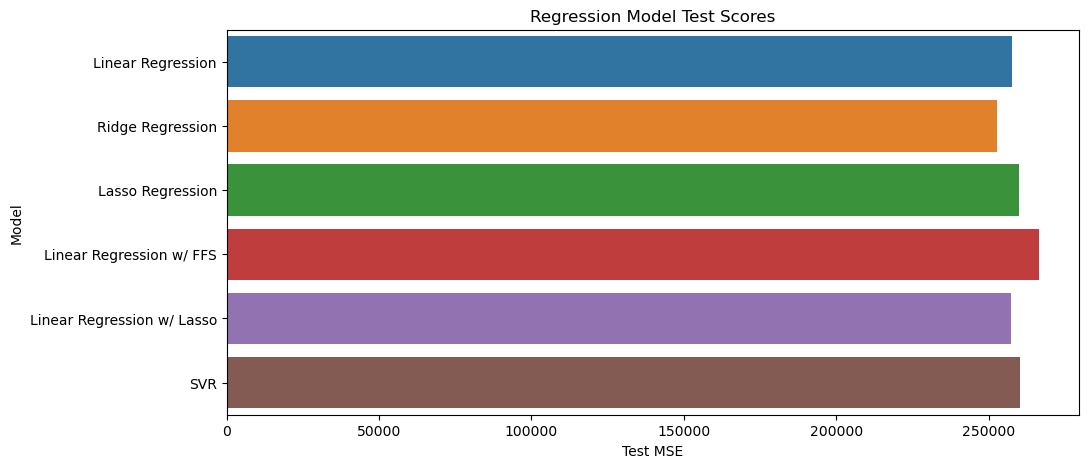

In [28]:
# test mse

plt.figure(figsize = [11, 5])
sns.barplot(results_df, y = 'Model', x = 'Test MSE', orient = 'h')
plt.title('Regression Model Test Scores')
plt.savefig('images/test_mse.png')

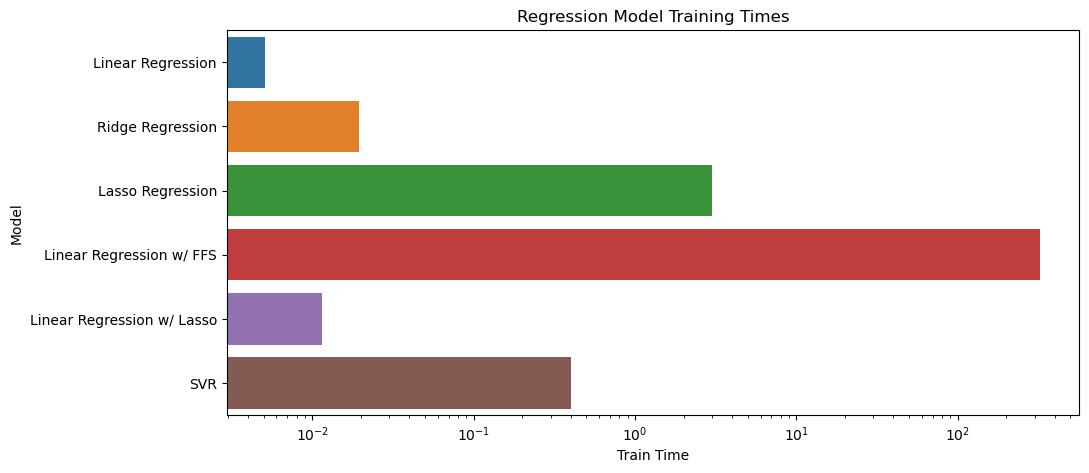

In [29]:
# train time

plt.figure(figsize = [11, 5])
fig = sns.barplot(results_df, y = 'Model', x = 'Train Time', orient = 'h')
fig.set_xscale('log')
plt.title('Regression Model Training Times')
plt.savefig('images/train_time.png')

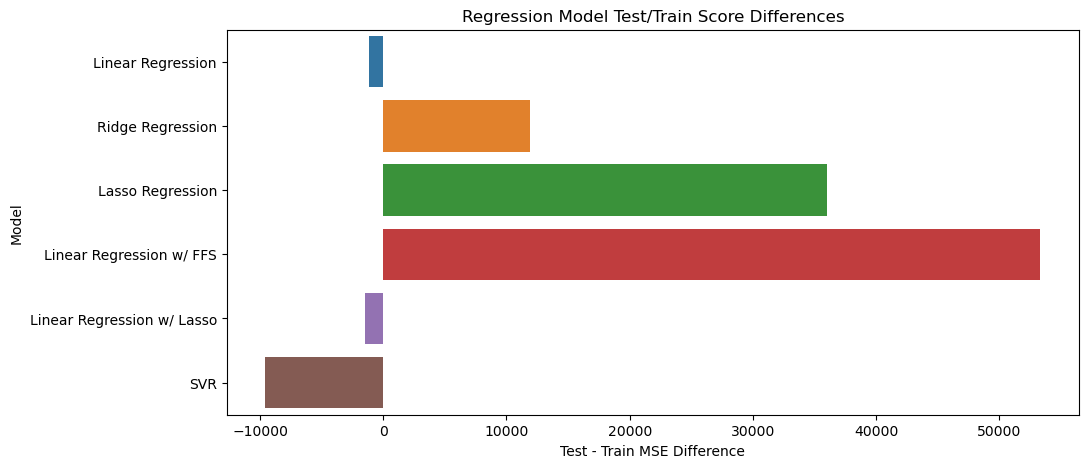

In [30]:
# visualize overfitting
results_df['Test - Train MSE Difference'] = results_df['Test MSE'] - results_df['Train MSE']

plt.figure(figsize = [11, 5])
fig = sns.barplot(results_df, y = 'Model', x = 'Test - Train MSE Difference', orient = 'h')
plt.title('Regression Model Test/Train Score Differences')
plt.savefig('images/overfit.png')

## Observations:
- All of the models performed about as well
    - Ridge Regression has a slight edge as the best performing model on test MSE
- Many of the models appear to show overfitting
    - The most egregious is Linear Regression w/ FFS, followed by Lasso, and Ridge Regression
    - Linear Regression, Linear Regression w/ Lasso, and SVR do not appear to show overfitting. Linear Regression and Linear Regression w/ Lasso have minimal differences between train and test MSE
- Linear Regression and Linear Regression w/ Lasso have the lowest training times. Every other model has a training time that is about an order of magnitude longer, if not more
- Linear Regression and Linear Regression w/ Lasso also selected models with the polynomial degree = 1, likely contributing to the low training time, and making these the most interpretable models
- It would appear that Linear Regression and Linear Regression w/ Lasso are the most optimal models, given that all the models perform about the same, but they show the least overfitting and lowest training times


In [31]:
# Examine feature coeficients for our best models: Linear Regression and Linear Regression w/ Lasso
# Also include Ridge Regression, as it performed the best

In [32]:
lr_feat_df.sort_values(by = 'abs coef', ascending = False)

,feature,coef,abs coef
18,angle_of_incidence,-400.99,400.99
20,azimuth,-399.39,399.39
10,shortwave_radiation_backwards_sfc,344.56,344.56
15,wind_speed_900_mb,-296.70,296.70
11,wind_speed_10_m_above_gnd,161.87,161.87
19,zenith,-153.43,153.43
3,mean_sea_level_pressure_MSL,111.85,111.85
13,wind_speed_80_m_above_gnd,108.60,108.60
2,relative_humidity_2_m_above_gnd,-99.84,99.84
1,temperature_2_m_above_gnd,-81.47,81.47


In [33]:
lr_lasso_feat_df.sort_values(by = 'abs coef', ascending = False)

,feature,coef,abs coef
18,angle_of_incidence,-401.24,401.24
20,azimuth,-395.66,395.66
10,shortwave_radiation_backwards_sfc,352.76,352.76
19,zenith,-156.03,156.03
15,wind_speed_900_mb,-145.07,145.07
13,wind_speed_80_m_above_gnd,109.92,109.92
3,mean_sea_level_pressure_MSL,109.48,109.48
2,relative_humidity_2_m_above_gnd,-98.38,98.38
1,temperature_2_m_above_gnd,-84.91,84.91
6,total_cloud_cover_sfc,-60.22,60.22


In [34]:
ridge_feat_df.sort_values(by = 'abs coef', ascending = False)[:10]

,feature,coef,abs coef
75,mean_sea_level_pressure_MSL angle_of_incidence,-87.25,87.25
18,angle_of_incidence,-85.90,85.90
226,angle_of_incidence zenith,-73.82,73.82
230,azimuth^2,-66.40,66.40
225,angle_of_incidence^2,-63.31,63.31
228,zenith^2,-61.09,61.09
19,zenith,-57.31,57.31
76,mean_sea_level_pressure_MSL zenith,-57.19,57.19
67,mean_sea_level_pressure_MSL shortwave_radiation_backwards_sfc,55.78,55.78
10,shortwave_radiation_backwards_sfc,54.24,54.24


In [35]:
ridge_feat_df.sort_values(by = 'abs coef', ascending = True)[:10]

,feature,coef,abs coef
0,1,0.00,0.00
93,total_precipitation_sfc zenith,-0.06,0.06
73,mean_sea_level_pressure_MSL wind_direction_900_mb,0.07,0.07
160,low_cloud_cover_low_cld_lay wind_direction_900_mb,-0.12,0.12
189,wind_direction_10_m_above_gnd wind_speed_900_mb,0.13,0.13
140,medium_cloud_cover_mid_cld_lay^2,0.17,0.17
194,wind_direction_10_m_above_gnd azimuth,-0.24,0.24
35,temperature_2_m_above_gnd wind_speed_900_mb,-0.26,0.26
101,snowfall_amount_sfc wind_speed_10_m_above_gnd,-0.28,0.28
16,wind_direction_900_mb,-0.29,0.29


The feature coefficients seem to consistently show that the positioning of the panel - angle of incidence, zenith, azimuth - has the greatest impact on power generated. This makes complete sense, as sunlight needs to be falling on the face of the panel in order for them to work best. In addition, backwards shortwave radiation seems to be very important too, which also makes perfect sense. This is a measure of visible spectrum radiation - in other words, panels that are located in areas of high sunlight generate the most power. In contrast, measures of snowfall and precipitation seem to have the least impact on the power generated, while other measures of meteorological conditions, such as wind speed, wind direction, and cloud cover, seem to fall somewhere in the middle. Mean sea level pressure appears to be more important than these factors, but less important than the position and radiation factors.

Put together, this would seem to indicate that the location of the panels in high-sunlight areas and the correct positioning of the panels to receive direct sunlight are far more important in generating power than daily weather variations.